In [1]:
! pwd

/media/ronit/SharedVolume/lwm_project/LWM


In [2]:
! which python

/home/ronit/anaconda3/envs/lwm_cuda/bin/python


In [6]:
import subprocess
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, random_split, TensorDataset
import csv, json, time
from sklearn.metrics import f1_score
from tqdm import tqdm  # Progress bar
import torch.optim as optim
import math




from input_preprocess import tokenizer
from lwm_model import lwm
from inference import lwm_inference, create_raw_dataset

In [7]:
# Define scenario names and select one (or more).
scenario_names = np.array([
    "city_18_denver", "city_15_indianapolis", "city_19_oklahoma", 
    "city_12_fortworth", "city_11_santaclara", "city_7_sandiego"
])
# Select the first scenario (index 0) – adjust as needed.
scenario_idxs = np.array([0, 1, 2, 3, 4, 5])[0:3]
selected_scenario_names = scenario_names[scenario_idxs]

snr_db = None
preprocessed_chs = tokenizer(
    selected_scenario_names=selected_scenario_names,
    manual_data=None,
    gen_raw=True,
    snr_db=snr_db
)


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 6970/6970 [00:00<00:00, 53303.78it/s]



Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 6320/6320 [00:00<00:00, 19561.38it/s]



Basestation 1

UE-BS Channels


Processing items: 100%|██████████| 8057/8057 [00:00<00:00, 45534.85it/s]


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using",device)
lwm_model = lwm.from_pretrained(device=device)

Using cuda
Model loaded successfully from model_weights.pth to cuda


In [9]:
#######SELECT INPUT##############################################

input_types = ['cls_emb', 'channel_emb', 'raw']
selected_input_type = input_types[2] # choose one: 'cls_emb', 'channel_emb', or 'raw'
if selected_input_type in ['cls_emb', 'channel_emb']:
    dataset = lwm_inference(preprocessed_chs, selected_input_type, lwm_model, device)
else:
    dataset = create_raw_dataset(preprocessed_chs, device)
# At this point, `dataset` should be a torch Dataset yielding (data, target) pairs.


Basestation 3

UE-BS Channels


Computing the channel for each user: 100%|██████████| 6970/6970 [00:00<00:00, 92564.57it/s]


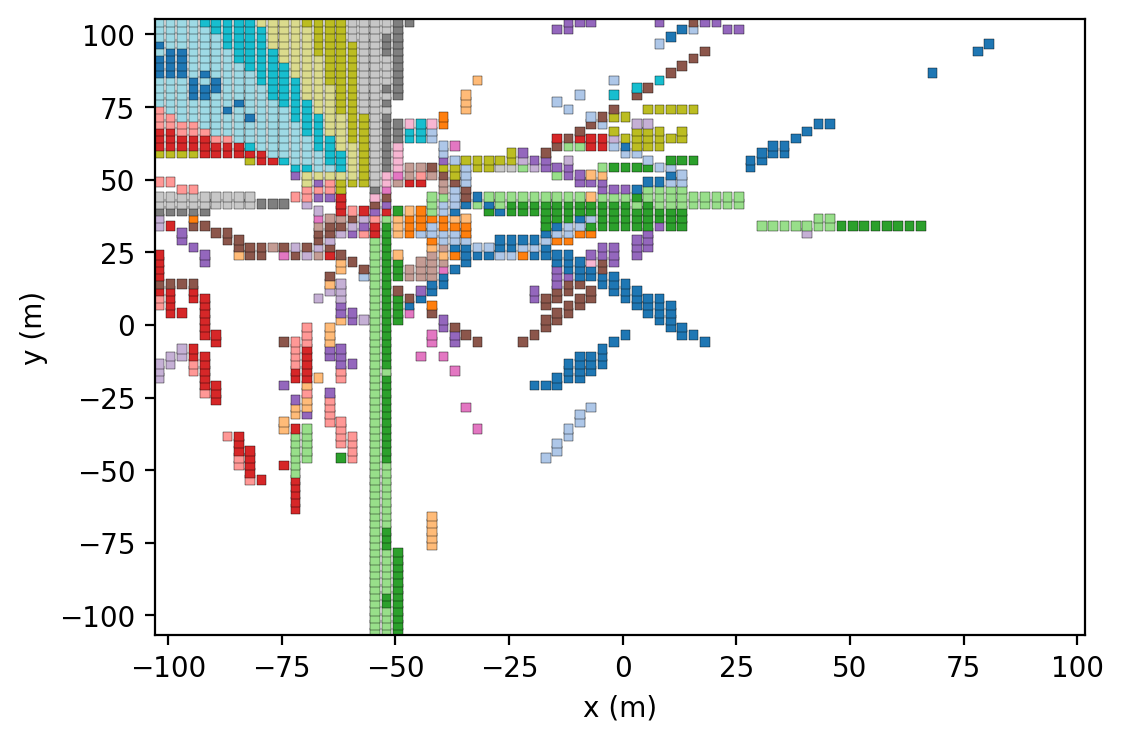


Basestation 3

UE-BS Channels


Computing the channel for each user: 100%|██████████| 6320/6320 [00:00<00:00, 55709.91it/s]


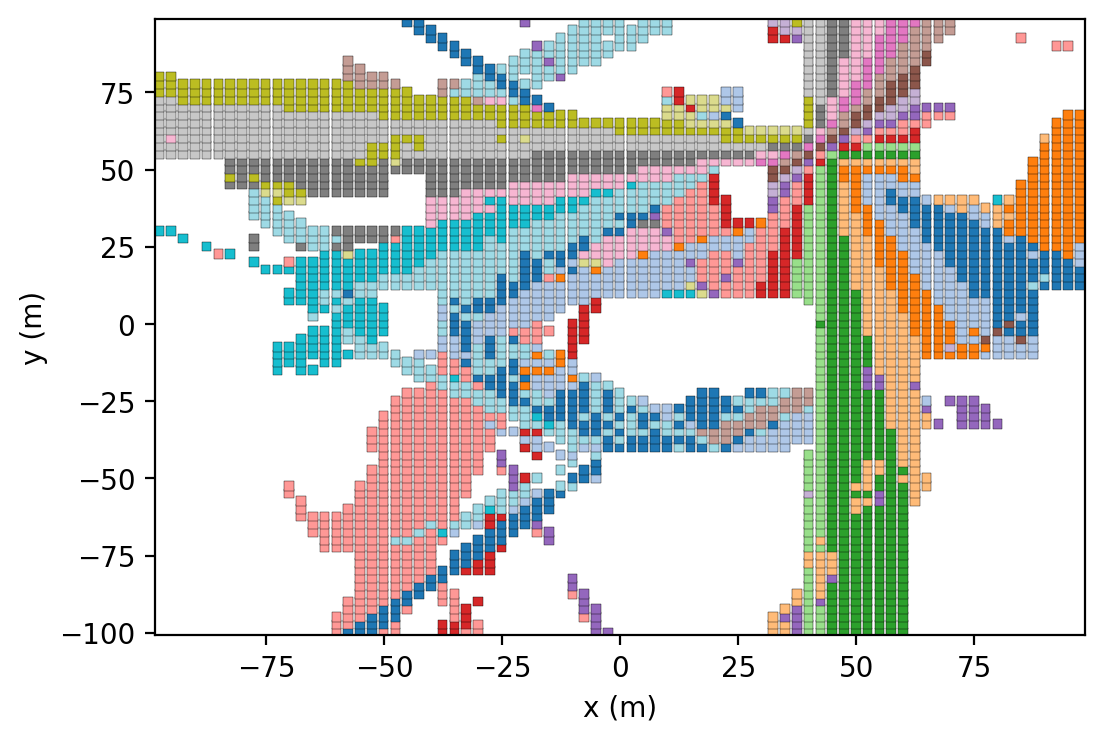


Basestation 1

UE-BS Channels


Computing the channel for each user: 100%|██████████| 6150/6150 [00:00<00:00, 47621.37it/s]


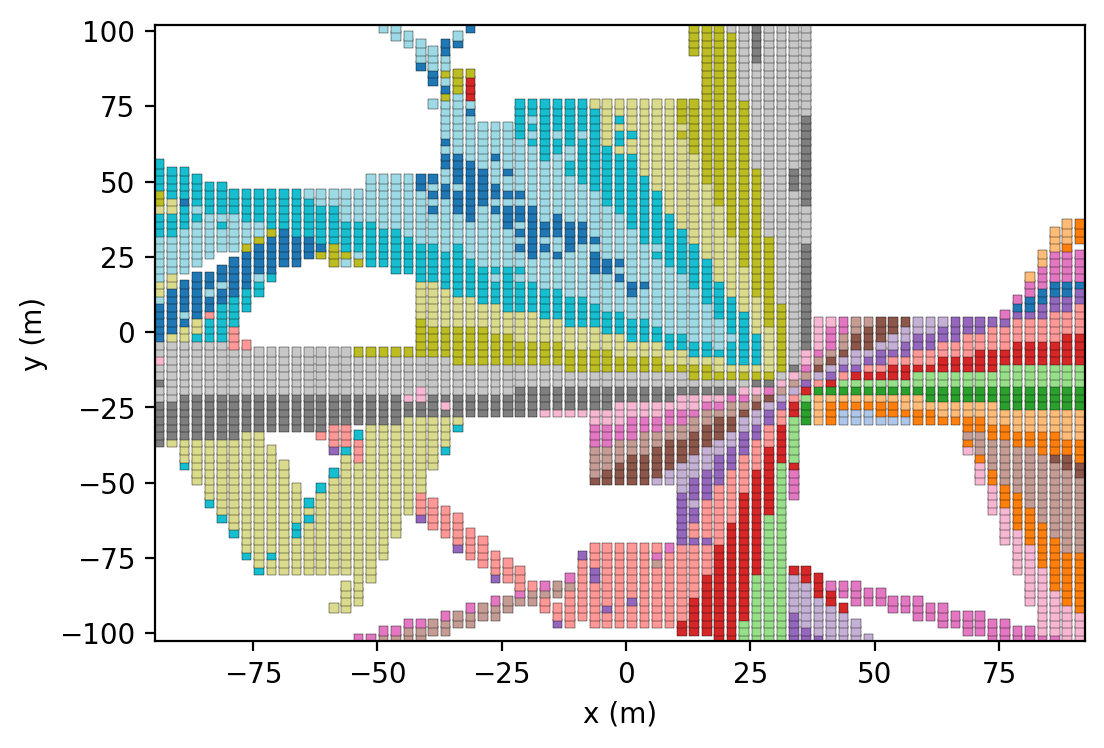

In [10]:
#generate targets/lables
from input_preprocess import create_labels
tasks = ['LoS/NLoS Classification', 'Beam Prediction']
task = tasks[1] # Choose 0 for LoS/NLoS labels or 1 for beam prediction labels.
labels = create_labels(task, selected_scenario_names, n_beams=64)

data:  <class 'torch.Tensor'> 8057 torch.Size([8057, 128, 16])
labels:  <class 'torch.Tensor'> 8057


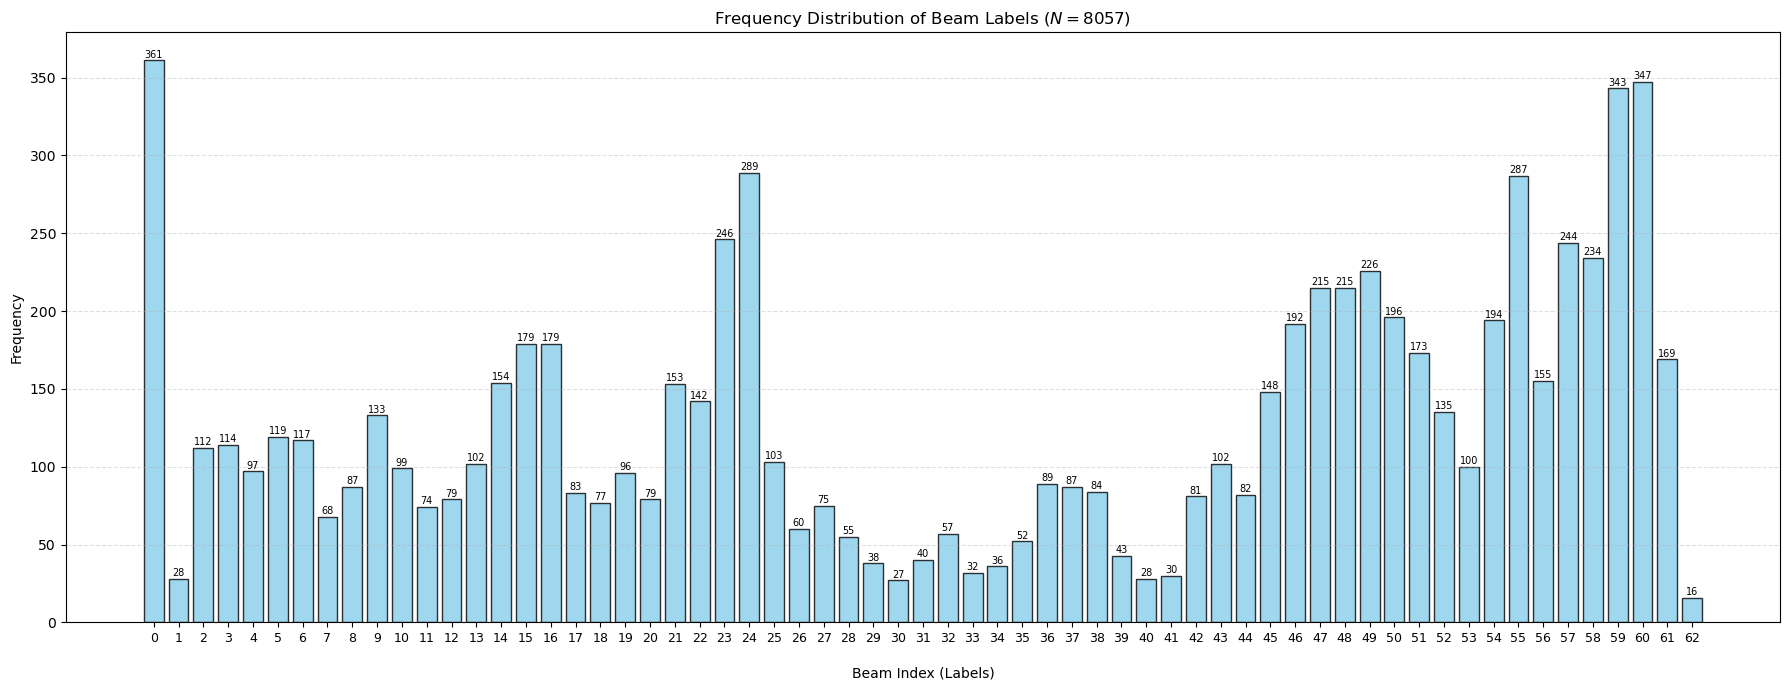

In [11]:
print("data: ",
type(dataset),
len(dataset),
dataset.shape
)
print("labels: ",
    type(labels),len(labels)
)


unique_labels, counts = torch.unique(labels, return_counts=True)
x_values = unique_labels.cpu().numpy()
y_values = counts.cpu().numpy()

# 2. Increase figure width (e.g., to 16 or 18) to create more horizontal space
plt.figure(figsize=(18, 7)) 

# 3. Create bars
bars = plt.bar(x_values, y_values, color='skyblue', edgecolor='black', alpha=0.8)

# Adding some padding with 'labelpad' if needed
plt.xticks(x_values, rotation=0, fontsize=9) 

# 5. Annotate each bar with its frequency count
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), 
             va='bottom', ha='center', fontsize=7, rotation=0)

# 6. Add labels and title
plt.xlabel('Beam Index (Labels)', labelpad=15)
plt.ylabel('Frequency')
plt.title(f'Frequency Distribution of Beam Labels ($N = {len(labels)}$)')

# 7. Use tight_layout to ensure no labels are cut off at the edges
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

In [12]:
#function to combine data and labels and split in the given train ratio ratio
def get_data_loaders(data_tensor, labels_tensor, batch_size=32, train_ratio=0.8):
    dataset = TensorDataset(data_tensor, labels_tensor)
    N = len(dataset)

    train_size = int(train_ratio * N)
    remaining = N - train_size
    val_size = remaining // 2
    test_size = remaining - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset,[train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [13]:
###############CHANGE MAPPING ACCORDINGLY#######################333

# Mapping for beam prediction input types.
mapping = {
    'cls_emb': {'input_channels': 1, 'sequence_length': 64},
    'channel_emb': {'input_channels': 64, 'sequence_length': 128},
    'raw': {'input_channels': 16, 'sequence_length': 128}
}
input_type = selected_input_type  # use the same type as for data generation
params = mapping.get(input_type, mapping['raw']) #change if chosen anything else
n_beams = 64  # adjust as needed
initial_lr = 0.001
num_classes = n_beams + 1  # as defined in your code

In [15]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        # Re-weight the original features (Excitation)
        return x * y.expand_as(x)

# 2. IMPROVED RESIDUAL BLOCK
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SEResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Add SE Layer to attend to important features
        self.se = SELayer(out_channels) 

        self.shortcut = nn.Sequential()
        if stride!= 1 or in_channels!= out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Apply Attention
        out = self.se(out) 
        
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# 3. MAIN MODEL
class SEResNet1D(nn.Module):
    def __init__(self, num_classes=64):
        super(SEResNet1D, self).__init__()
        # Stem: Aggressive initial downsampling to reduce noise
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Deeper Layers with Attention
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.3) 
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_c, out_c, stride):
        # Using 2 blocks per layer for more depth
        layers = []
        layers.append(SEResidualBlock(in_c, out_c, stride))
        layers.append(SEResidualBlock(out_c, out_c, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

print("Improved SE-ResNet1D Model Defined.")

# A. Label Smoothing Loss Function
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

Improved SE-ResNet1D Model Defined.


In [17]:
# Instantiate the beam prediction model.

# beam_model = res1dcnn(params['input_channels'], params['sequence_length'], num_classes).to(device)
beam_model = SEResNet1D(num_classes).to(device)

optimizer = Adam(beam_model.parameters(), lr=initial_lr, weight_decay=1e-4)

# scheduler = MultiStepLR(optimizer, milestones=[15, 35], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
    T_0=10,      # Restart every 10 epochs
    T_mult=2,    # Double the restart interval (10, 20, 40...)
    eta_min=1e-6 # Minimum LR
)

print("Advanced Optimizer and Scheduler Initialized.")


num_epochs = 50

# Create DataLoaders (assuming `dataset` is a torch Dataset with (data, target) pairs).
batch_size = 32  # adjust as needed

train_loader, val_loader, test_loader = get_data_loaders(dataset, labels, train_ratio=0.4)
print("train: ",len(train_loader),'\n','validate: ',len(val_loader),'\n','test: ', len(test_loader))

# Function to plot training metrics.
def plot_training_metrics(epochs, train_losses, val_losses, val_f1_scores, save_path=None):
    plt.figure(figsize=(12, 5))
    # Loss plot.
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    # F1 score plot.
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label='Validation Weighted F1', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Weighted F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

Advanced Optimizer and Scheduler Initialized.
train:  101 
 validate:  76 
 test:  76


In [18]:
# Training loop with weighted F1 computation.

# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingLoss(classes=64, smoothing=0.1)

train_losses = []
val_losses = []
val_f1_scores = []
epochs_list = []

for epoch in range(1, num_epochs + 1):
    beam_model.train()
    running_loss = 0.0
    # Training with tqdm progress bar.
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        data, target = data.to(device), target.to(device)
        # Adjust input shape based on type.
        if input_type == 'raw':
            data = data.view(data.size(0), params['sequence_length'], params['input_channels'])
        elif input_type == 'cls_emb':
            data = data.unsqueeze(2)
        optimizer.zero_grad()
        outputs = beam_model(data)
        loss = criterion(outputs, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(beam_model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    scheduler.step()
    train_loss = running_loss / len(train_loader.dataset)
    
    # Validation loop with tqdm.
    beam_model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_targets = []
    for data, target in tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False):
        data, target = data.to(device), target.to(device)
        if input_type == 'raw':
            data = data.view(data.size(0), params['sequence_length'], params['input_channels'])
        elif input_type == 'cls_emb':
            data = data.unsqueeze(2)
        outputs = beam_model(data)
        loss = criterion(outputs, target)
        val_running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
    val_loss = val_running_loss / len(val_loader.dataset)
    val_f1 = f1_score(all_targets, all_preds, average='weighted')
    
    epochs_list.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    
    print(f"Epoch {epoch}/{num_epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Weighted F1: {val_f1:.4f}")

RuntimeError: Given groups=1, weight of size [64, 1, 7], expected input[32, 128, 16] to have 1 channels, but got 128 channels instead

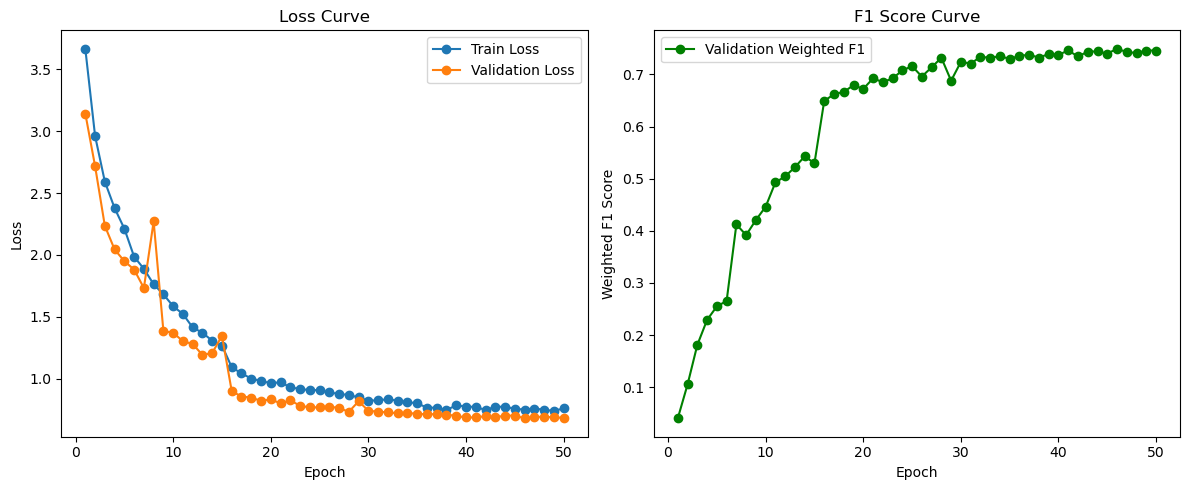

Testing: 100%|██████████| 76/76 [00:00<00:00, 550.13it/s]

Test Loss: 0.6717, Test Accuracy: 76.05%
101 76 76


In [18]:
# Plot training metrics.
plot_training_metrics(epochs_list, train_losses, val_losses, val_f1_scores)

# Test evaluation with tqdm.
beam_model.eval()
test_running_loss = 0.0
correct = 0
total = 0
for data, target in tqdm(test_loader, desc="Testing"):
    data, target = data.to(device), target.to(device)
    if input_type == 'raw':
        data = data.view(data.size(0), params['sequence_length'], params['input_channels'])
    elif input_type == 'cls_emb':
        data = data.unsqueeze(2)
    outputs = beam_model(data)
    loss = criterion(outputs, target)
    test_running_loss += loss.item() * data.size(0)
    _, predicted = torch.max(outputs, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()
test_loss = test_running_loss / len(test_loader.dataset)
accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
print(len(train_loader),len(test_loader),len(val_loader))